# Accumulating Errors
Accelerometers are often **biased**. That means that even when acceleration is zero, they measure some non-zero value. Bias can be reduced through careful calibration (and buying better sensors) but it's hard to remove entirely.

In this notebook you'll briefly explore how bias tends to accumulate.

----

## Part 1 - What is Bias?
A sensor is biased when it consistently reports a number that is too high or too low. Remember the elevator acceleration data?

The code below is similar to what you used to plot that data.

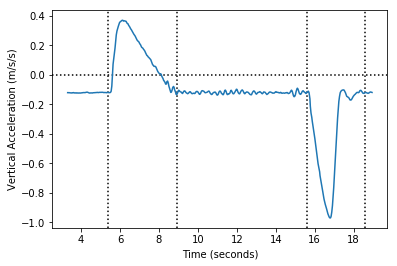

In [1]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

# get elevator data
data = np.genfromtxt("elevator-lac.csv", delimiter=",")[100:570]

# unpack that data
t, a_x, a_y, a_z = data.T
plt.ylabel("Vertical Acceleration (m/s/s)")
plt.xlabel("Time (seconds)")
region_delimiters = [5.4, 8.9, 15.6, 18.6]
for x_val in region_delimiters:
    plt.axvline(x=x_val, color="black",linestyle='dotted')

plt.axhline(y=0, color='black',linestyle='dotted')
plt.plot(t, a_z) 
plt.show()


In [5]:
at=a_z[10:14]
print(at)

[-0.121938 -0.122866 -0.122678 -0.121491]


Note how the flat parts of the graph (0 acceleration) do NOT line up with the dotted $a=0$ line. But they should!

This offset is due to **bias** in the accelerometer.

If we know there's a bias we can correct it manually.

**TODO - Correct the bias**
> Change the second to last line of code in the code cell above to the following
> ```python
> plt.plot(t, a_z+0.12) 
> ```
> and then re-run the cell.

## Part 2 - Visualize the Effect of Bias on `discrete` data

### Rewriting `get_integral_from_data` with bias

In the code cell below you will see how I've rewritten this function to include an **optional** third parameter called `bias`. The default value for this parameter is zero.

When this parameter is non-zero, it simulates (or corrects) an offset in the data.

In [2]:
def get_integral_from_data(acceleration_data, times, bias=0.0):
    """
    Numerically integrates data AND artificially introduces 
    bias to that data.
    
    Note that the bias parameter can also be used to offset
    a biased sensor.
    """
    accumulated_speed = 0.0
    last_time = times[0]
    speeds = []
    for i in range(1, len(times)):
        
        # THIS is where the bias is introduced. No matter what the 
        # real acceleration is, this biased accelerometer adds 
        # some bias to the reported value.
        acceleration = acceleration_data[i] + bias
        
        time = times[i]
        delta_t = time - last_time
        delta_v = acceleration * delta_t
        accumulated_speed += delta_v
        speeds.append(accumulated_speed)
        last_time = time
    return speeds

**TODO - plot velocity and acceleration with and without bias**

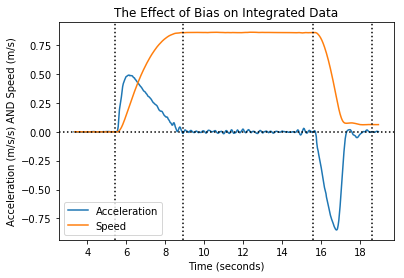

In [6]:
# TODO 
#   0. read through the code below to get a sense for what it does.
#   1. run this cell with OFFSET = 0.0
#   2. look at the graph. Note how drastic the error is with the
#      integrated speed! 
#   3. change OFFSET to OFFSET = 0.12 and re-run the cell

OFFSET = 0.12

plt.title("The Effect of Bias on Integrated Data")
plt.xlabel("Time (seconds)")
plt.ylabel("Acceleration (m/s/s) AND Speed (m/s)")

# get the elevator speeds by integrating the acceleration data
elevator_speeds = get_integral_from_data(a_z, t, OFFSET)

# plot acceleration data
plt.plot(t, a_z+OFFSET) 

# plot INFERRED (from integration) speed data
plt.plot(t[1:], elevator_speeds)

# add a legend to the plot
plt.legend(["Acceleration", "Speed"])

# vertical lines
region_delimiters = [5.4, 8.9, 15.6, 18.6]
for x_val in region_delimiters:
    plt.axvline(x=x_val, color="black",linestyle='dotted')

# a=0 reference line
plt.axhline(y=0, color='black',linestyle='dotted')

plt.show()

When `OFFSET = 0.0`, the speed graph looks absurd! It says that the speed of the elevator at the end of the journey is $-1.8$ m/s (clearly it should be 0.0). 

And note that the effect of bias gets worse (for the speed graph) as time goes on! 

When `OFFSET = 0.12` this graph looks much more reasonable (though still not perfect).

> We should be more suspicious of integrated data when the integrations happen over a long period of time. 

## Part 3 - The Effect of Repeated Integration

You saw that bias has a bigger impact on integrated data when we give that data time to accumulate. What happens when we integrate **twice**?

In [7]:
# This is just a helper function for integrating twice.
def double_integral(data, times, bias=0.0):
    print(bias)
    speeds = get_integral_from_data(data, times, bias)
    displacements = get_integral_from_data(speeds, times[1:])
    return displacements

**TODO - Observe effect of bias on double integration**

> 1. Run the cell below (OFFSET = 0.12). This shows the elevator ascending to a height of about 8 meters.
> 2. Change OFFSET to 0.0 and rerun. Look at how bad this inferred position is! It looks like we actually went DOWN.

0.12


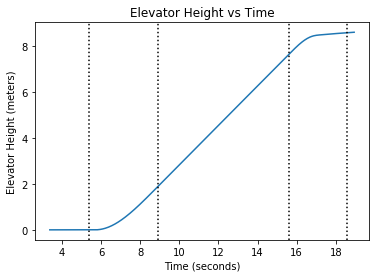

In [10]:
OFFSET = 0.12

plt.title("Elevator Height vs Time")
plt.xlabel("Time (seconds)")
plt.ylabel("Elevator Height (meters)")

displacements = double_integral(a_z, t, OFFSET)
plt.plot(t[2:], displacements)

# vertical lines
region_delimiters = [5.4, 8.9, 15.6, 18.6]
for x_val in region_delimiters:
    plt.axvline(x=x_val, color="black",linestyle='dotted')

plt.show()

## Part 4 - Parallel Parking

Same walkthrough, different data. Note that this time the accelerometer is "perfect" (because the data here is faked) and we will be using the `bias` parameter to *introduce* bias (instead of *correcting* it).

In [11]:
from helpers import process_data

PARALLEL_PARK_DATA = process_data("parallel_park.pickle")

TIMESTAMPS    = [row[0] for row in PARALLEL_PARK_DATA]
DISPLACEMENTS = [row[1] for row in PARALLEL_PARK_DATA]
YAW_RATES     = [row[2] for row in PARALLEL_PARK_DATA]
ACCELERATIONS = [row[3] for row in PARALLEL_PARK_DATA]

#### Observing the Effects of bias
Run the code cell below. You'll see that when bias is really small (like 0.01), the reported acceleration (blue dots) agrees very well with the actual acceleration (orange dots).

When bias is increased, things get bad fast!

0.4


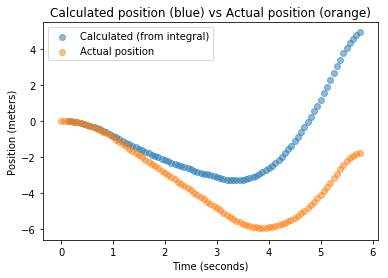

In [17]:
# Try running this cell with BIAS set to 0.01, 0.05, 0.1, 0.2, 0.4
# and so on. Even though these are all small numbers the effect of 
# bias tends to accumulate as the sensor runs for longer and longer.

BIAS = 0.4

integrated_displacements = double_integral(ACCELERATIONS, TIMESTAMPS, BIAS)

plt.title("Calculated position (blue) vs Actual position (orange)")
plt.xlabel("Time (seconds)")
plt.ylabel("Position (meters)")
plt.scatter(TIMESTAMPS[2:], integrated_displacements, alpha=0.5)
plt.scatter(TIMESTAMPS, DISPLACEMENTS, alpha=0.5)
plt.legend(["Calculated (from integral)", "Actual position"])
plt.show()